# Ranking the drawdowns of Index constituents

It is useful to keep a tab on drawdowns of index constituents to get a feel for how the index is diverging/converging from individual stock performance. For example, 7 stocks account for 50% of the NIFTY 50's performance and end up masking the performance of the other 43. If the rest are crashing, how long will the best hold up?

StockViz has an automated report on drawdowns of NIFTY 100, MIDCAP 150 and SMLCAP 100 constituents that gets generated everyday [here](https://stockviz.github.io/reports/drawdown/drawdowns.html). The [underlying code](https://github.com/stockviz/reports/tree/master/drawdown) is an R-markdown script who's output gets pushed to github. In this notebook, by setting the *indexName* variable to any NSE/NIFTY index that we have constituents for, you can generate the same report for yourself on [pluto](http://pluto.studio).

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

#initialize
indices<-Indices()
equitiesIndiaNse <- EquitiesIndiaNse()

indexName <- "NIFTY 50"
endDate <- Sys.Date()
startDate <- endDate - 365 

In [2]:
maxDt <- (indices$NseConstituents() %>%
          filter(NAME == indexName) %>%
          summarize(MAX_TS = max(TIME_STAMP)) %>% 
          collect())$MAX_TS[1]

constituents <- indices$NseConstituents() %>%
    filter(TIME_STAMP == maxDt & NAME == "NIFTY 50") %>%
    collect() %>%
    as.data.frame()

### plot the weights to get a feel for individual contributions

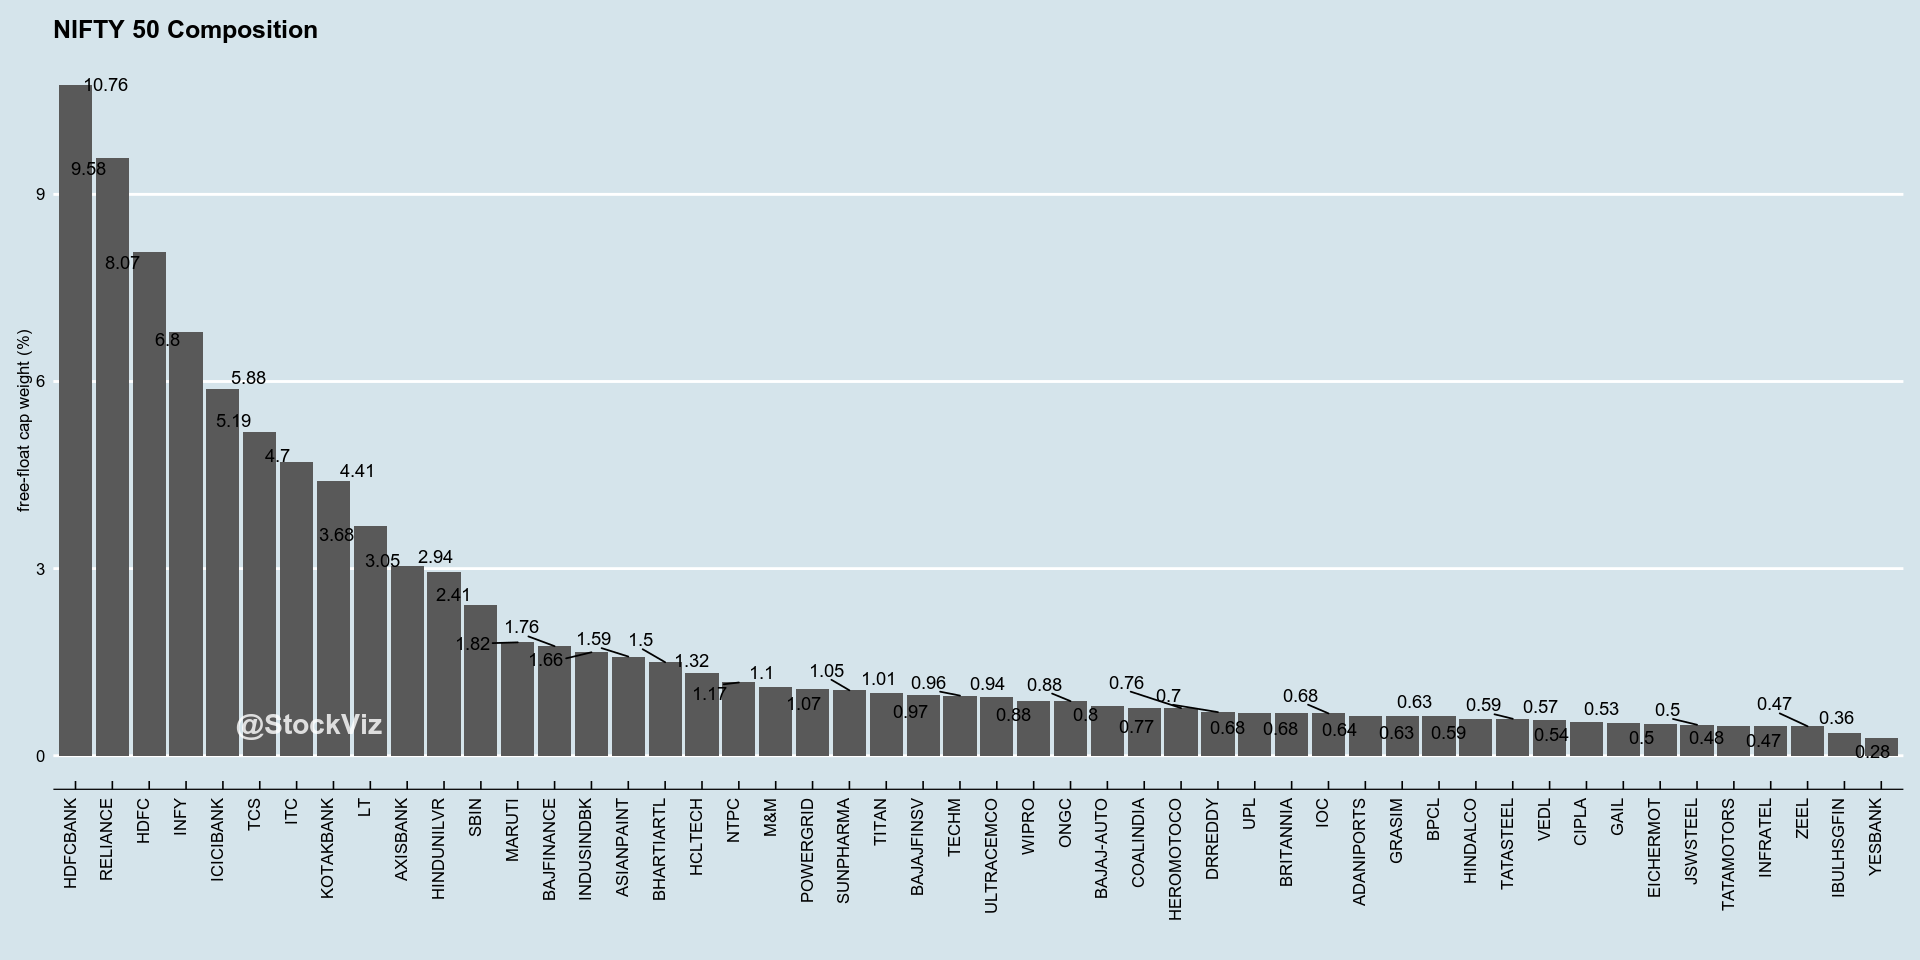

In [3]:
toPlot <- constituents

ggplot(toPlot, aes(x=reorder(SYMBOL, -CAP_WEIGHT), y=CAP_WEIGHT)) +
    theme_economist() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    geom_bar(stat="identity", position=position_dodge()) +
    geom_text_repel(aes(label=round(CAP_WEIGHT, 2)), position = position_dodge(0.9)) +
    labs(x='', y='free-float cap weight (%)', color='', fill='', title=sprintf("%s Composition", indexName)) +
    annotate("text", x=1, y=0, label = "@StockViz", 
             hjust=-1.1, vjust=-1.1, col="white", cex=6, fontface = "bold", alpha = 0.8)

#### modify the drawdown report *genTables* function to work on pluto

In [5]:
# https://github.com/shyams80/plutons/blob/master/docs-R/EquitiesIndiaNse.ipynb

endDate <- as.Date((equitiesIndiaNse$DailyReturns() %>%
            filter(TIME_STAMP <= endDate) %>%
            summarize(MAX_DT = max(TIME_STAMP)) %>%
            collect())$MAX_DT[[1]])

numCalDays <- as.integer(endDate-startDate)
ongoingDf <- data.frame(SYMBOL = "", FROM="", DEPTH = 0.0)
recoveringDf <- data.frame(SYMBOL = "", FROM="", TROUGH="", DEPTH = 0.0, BOUNCE = 0.0)
for(sym in constituents$SYMBOL){
    retSeries <- equitiesIndiaNse$DailyReturns() %>%
        filter(SYMBOL == sym & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
    if(nrow(retSeries) < 0.5*numCalDays) next
    if(last(retSeries$TIME_STAMP) != endDate) next

    retXts <- xts(retSeries$VALUE, retSeries$TIME_STAMP)
    tdd <- table.Drawdowns(retXts, 10)

    notRec <- tdd[is.na(tdd$Recovery),]
    if(nrow(notRec) > 0) {
        ongoingDf <- rbind(ongoingDf, c(toString(sym), toString(notRec$From[1]), notRec$Depth[1]))
    }

    recovering <- notRec[!is.na(notRec$Trough) & notRec$Trough < endDate,]
    if(nrow(recovering) > 0) {
        deepest <- recovering[order(recovering$Depth),][1,]
        fromDt <- as.Date(deepest$Trough[1])
        bounce <- Return.cumulative(retXts[sprintf("%s/%s", fromDt, endDate)])

        if (bounce > 0) {
            recoveringDf <- rbind(recoveringDf, c(toString(sym), 
                                                  toString(deepest$From[1]), toString(fromDt), 
                                                  deepest$Depth[1], bounce))
        }
    }
}

ongoingDf <- ongoingDf[-1,]
recoveringDf <- recoveringDf[-1,]

ongoingDf$DEPTH <- 100*as.numeric(ongoingDf$DEPTH)
recoveringDf$DEPTH <- 100*as.numeric(recoveringDf$DEPTH)
recoveringDf$BOUNCE <- round(100*as.numeric(recoveringDf$BOUNCE), 2)

ongoingDf <- ongoingDf[order(ongoingDf$DEPTH),]
recoveringDf <- recoveringDf[order(recoveringDf$BOUNCE, decreasing = T),]

### Ongoing Drawdowns

In [6]:
print(ongoingDf)

       SYMBOL       FROM  DEPTH
50    YESBANK 2018-09-19 -82.63
23 IBULHSGFIN 2018-09-17 -63.85
41 TATAMOTORS 2018-09-17 -59.60
30   JSWSTEEL 2018-09-21 -49.83
14  EICHERMOT 2018-09-18 -48.13
33        M&M 2018-09-24 -47.00
42  TATASTEEL 2018-09-24 -45.89
40  SUNPHARMA 2018-09-17 -44.49
48       VEDL 2018-09-27 -42.95
51       ZEEL 2018-12-18 -37.21
15       GAIL 2018-09-24 -36.78
34     MARUTI 2018-09-17 -36.54
16     GRASIM 2018-09-21 -35.65
36       ONGC 2019-05-23 -33.89
12  COALINDIA 2018-10-30 -33.68
20 HEROMOTOCO 2018-12-21 -31.41
28        IOC 2019-06-04 -30.78
21   HINDALCO 2018-10-04 -30.74
11      CIPLA 2018-09-27 -30.59
25 INDUSINDBK 2018-09-18 -30.44
47        UPL 2019-07-05 -27.97
39       SBIN 2019-07-18 -27.94
10  BRITANNIA 2019-02-05 -26.55
35       NTPC 2018-09-17 -24.25
44      TECHM 2019-05-03 -23.79
26   INFRATEL 2019-03-20 -23.76
9        BPCL 2019-06-04 -23.53
45      TITAN 2019-07-01 -22.99
29        ITC 2019-04-18 -22.20
4    AXISBANK 2019-06-06 -21.90
6  BAJAJ

### Recovering

In [7]:
print(recoveringDf)

       SYMBOL       FROM     TROUGH  DEPTH BOUNCE
8        BPCL 2019-06-04 2019-08-22 -23.53  17.21
30     MARUTI 2018-09-17 2019-07-31 -36.54  16.51
4  BAJAJ-AUTO 2019-04-26 2019-07-30 -19.62  14.68
18 HEROMOTOCO 2018-12-21 2019-07-30 -31.41  13.99
36  SUNPHARMA 2018-09-17 2019-07-08 -44.49  13.99
37 TATAMOTORS 2018-09-17 2019-08-22 -59.60  13.84
9   BRITANNIA 2019-02-05 2019-08-21 -26.55  11.42
39      TECHM 2019-05-03 2019-08-01 -23.79  10.85
31       NTPC 2018-09-17 2019-02-11 -24.25  10.50
11    DRREDDY 2019-05-08 2019-08-16 -15.35  10.13
19   HINDALCO 2018-10-04 2019-08-05 -30.74   9.04
12  EICHERMOT 2018-09-18 2019-08-23 -48.13   7.46
34   RELIANCE 2019-05-06 2019-08-07 -20.94   7.25
6  BAJFINANCE 2019-07-05 2019-07-25 -19.11   6.58
42        UPL 2019-07-05 2019-08-13 -27.97   6.34
2  ADANIPORTS 2019-07-17 2019-08-22 -17.48   6.21
38  TATASTEEL 2018-09-24 2019-09-03 -45.89   5.86
20 IBULHSGFIN 2018-09-17 2019-09-09 -63.85   5.56
22 INDUSINDBK 2018-09-18 2019-09-05 -30.44   5.51


### Cap-weight + deepest drawdown

In [8]:
toPlot <- merge(constituents[, c('SYMBOL', 'CAP_WEIGHT')], ongoingDf[, c('SYMBOL', 'DEPTH')], by='SYMBOL')
toPlot <- toPlot[order(toPlot$CAP_WEIGHT, decreasing = T),]
print(toPlot)

       SYMBOL CAP_WEIGHT  DEPTH
18   HDFCBANK    10.7571 -12.44
37   RELIANCE     9.5842 -20.94
17       HDFC     8.0709 -13.62
26       INFY     6.7985  -2.83
23  ICICIBANK     5.8794 -11.66
42        TCS     5.1900  -6.28
28        ITC     4.7013 -22.20
30  KOTAKBANK     4.4074  -8.34
31         LT     3.6759 -19.41
3    AXISBANK     3.0470 -21.90
21 HINDUNILVR     2.9398  -4.06
38       SBIN     2.4093 -27.94
33     MARUTI     1.8177 -36.54
6  BAJFINANCE     1.7564 -19.11
24 INDUSINDBK     1.6586 -30.44
2  ASIANPAINT     1.5902  -5.97
7  BHARTIARTL     1.4989  -9.49
16    HCLTECH     1.3187 -16.33
34       NTPC     1.1742 -24.25
32        M&M     1.1015 -47.00
36  POWERGRID     1.0724  -7.43
39  SUNPHARMA     1.0487 -44.49
44      TITAN     1.0110 -22.99
5  BAJAJFINSV     0.9683 -21.08
43      TECHM     0.9639 -23.79
45 ULTRACEMCO     0.9399 -20.28
48      WIPRO     0.8827 -15.39
35       ONGC     0.8750 -33.89
4  BAJAJ-AUTO     0.8049 -19.62
11  COALINDIA     0.7701 -33.68
19 HEROM